# Introduction to H2O's GLM using Lending Club Loan Data

[H2O](http://h2o-release.s3.amazonaws.com/h2o/latest_stable.html) is a scalable, distributed machine learning platform with interfaces in Python, R, and Flow (Web).

## The H2O Python Module

The [H2O Python Module](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html) module provides access to H2O clusters and uses conventions from [scikit-learn](http://scikit-learn.org) and [pandas](https://pandas.pydata.org). Installation instructions for this module are available on the [Install in Python](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python) section of H2O's on-line documentation.

In [1]:
import h2o

In [2]:
help(h2o)

Help on package h2o:

NAME
    h2o - :mod:`h2o` -- module for using H2O services.

DESCRIPTION
    (please add description).

PACKAGE CONTENTS
    assembly
    astfun
    automl (package)
    backend (package)
    cross_validation
    demos
    display
    estimators (package)
    exceptions
    expr
    expr_optimizer
    frame
    grid (package)
    group_by
    h2o
    job
    model (package)
    schemas (package)
    transforms (package)
    two_dim_table
    utils (package)

FUNCTIONS
    api(endpoint, data=None, json=None, filename=None, save_to=None)
        Perform a REST API request to a previously connected server.
        
        This function is mostly for internal purposes, but may occasionally be useful for direct access to
        the backend H2O server. It has same parameters as :meth:`H2OConnection.request <h2o.backend.H2OConnection.request>`.
    
    as_list(data, use_pandas=True, header=True)
        Convert an H2O data object into a python-specific object.
       

## Starting and Connecting to an H2O Cluster

The [h2o](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html#h2o-cluster-inspection) Python module contains the [`init`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=init#h2o.init) function to connecting and potentially starting a local H2O cluster. It also has the [`connect`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=connect#h2o.connect) function for connecting to an existing H2O cluster, remote or local.

In [3]:
h2o.init(max_mem_size = "6g") # use h2o.connect() for an existing h2o cluster

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/wk/m00ydfj52f9fl7zvx5cjztgc0000gn/T/tmpiqqupgi9
  JVM stdout: /var/folders/wk/m00ydfj52f9fl7zvx5cjztgc0000gn/T/tmpiqqupgi9/h2o_patrickaboyoun_started_from_python.out
  JVM stderr: /var/folders/wk/m00ydfj52f9fl7zvx5cjztgc0000gn/T/tmpiqqupgi9/h2o_patrickaboyoun_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_patrickaboyoun_3fq61x
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Data in H2O

### Data Import

The most common function for loading data into an H2O cluster is to use the [`import_file`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=import_file#h2o.import_file) on files that are visible to the cluster using either a server-side file system path, HDFS path, S3, or a URL. If the data files are local to the Python client, the [`upload_file`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=upload_file#h2o.upload_file) function uploads files based upon a local path to the H2O cluster.

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:


* **loan_amnt**: Requested loan amount (US dollars)
* **term**: Loan term length (months)
* **int_rate**: Recommended interest rate
* **emp_length**: Employment length (years)
* **home_ownership**: Housing status
* **annual_inc**: Annual income (US dollars)
* **purpose**: Purpose for the loan
* **addr_state**: State of residence
* **dti**: Debt to income ratio
* **delinq_2yrs**: Number of delinquencies in the past 2 years
* **revol_util**: Percent of revolving credit line utilized
* **total_acc**: Number of active accounts
* **bad_loan**: Bad loan indicator
* **longest_credit_length**: Age of oldest active account
* **verification_status**: Income verification status

In [4]:
train_path = "https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv"
train = h2o.import_file(train_path, destination_frame = "loan_train")

Parse progress: |█████████████████████████████████████████████████████████| 100%


### The H2OFrame

Data in an H2O cluster are represented as [`H2OFrame`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html) objects in Python. These objects have pandas-like methods for data manipulations. Two of the most important attributes of these objects are [`col_names`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=col_names#h2o.frame.H2OFrame.col_names) attribute, which contain the column names, and
[`types`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=types#h2o.frame.H2OFrame.types), which contain the data types for each of the columns. A third important attribute is the [`frame_id`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=frame_id#h2o.frame.H2OFrame.frame_id), which is the key for the H2OFrame within the H2O cluster.

In the case of the lending club loan data, the binary outcome, "bad_loan", was interpreted as integer and so is coerced to a categorical / enum / factor using the [`asfactor`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=asfactor#h2o.frame.H2OFrame.asfactor) method.

In [5]:
type(train)

h2o.frame.H2OFrame

In [6]:
help(h2o.H2OFrame)

Help on class H2OFrame in module h2o.frame:

class H2OFrame(builtins.object)
 |  Primary data store for H2O.
 |  
 |  H2OFrame is similar to pandas' ``DataFrame``, or R's ``data.frame``. One of the critical distinction is that the
 |  data is generally not held in memory, instead it is located on a (possibly remote) H2O cluster, and thus
 |  ``H2OFrame`` represents a mere handle to that data.
 |  
 |  Methods defined here:
 |  
 |  __abs__(self)
 |      # unops
 |  
 |  __add__(self, rhs)
 |      # Binary operations
 |  
 |  __and__(self, rhs)
 |  
 |  __contains__(self, lhs)
 |  
 |  __div__(self, rhs)
 |  
 |  __eq__(self, rhs)
 |      Return self==value.
 |  
 |  __float__(self)
 |  
 |  __floordiv__(self, rhs)
 |  
 |  __ge__(self, rhs)
 |      Return self>=value.
 |  
 |  __getitem__(self, item)
 |      Frame slicing, supports row and column slicing.
 |      
 |      :param item: selector of a subframe. This can be one of the following:
 |      
 |          - an int, indicating se

In [7]:
train.col_names

['loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'bad_loan',
 'longest_credit_length',
 'verification_status']

In [8]:
train.types

{'loan_amnt': 'int',
 'term': 'enum',
 'int_rate': 'real',
 'emp_length': 'int',
 'home_ownership': 'enum',
 'annual_inc': 'real',
 'purpose': 'enum',
 'addr_state': 'enum',
 'dti': 'real',
 'delinq_2yrs': 'int',
 'revol_util': 'real',
 'total_acc': 'int',
 'bad_loan': 'int',
 'longest_credit_length': 'int',
 'verification_status': 'enum'}

In [9]:
print(train.frame_id)

loan_train


In [10]:
train["bad_loan"] = train["bad_loan"].asfactor()

In [11]:
print(train.frame_id)

py_1_sid_b77f


### Exploratory Data Analysis in H2O

#### A Quick Look at the Target Variable

We will begin our exploration with a quick look at the frequency of bad loan status in the data using H2OFrame's [`table`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=table#h2o.frame.H2OFrame.table) method. Since the `table` method returns an H2OFrame, it is converted to a pandas DataFrame using the [`as_data_frame`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=as_data_frame#h2o.frame.H2OFrame.as_data_frame) method. The bad loan rate for customers in this data set is roughly 18%.

In [12]:
tbl = train["bad_loan"].table()
tbl = tbl.as_data_frame()

print(tbl)
print("\nFraction of bad_loan = {:0.4f}".format(tbl[tbl["bad_loan"] == 1]["Count"].values[0] / tbl["Count"].sum()))

   bad_loan   Count
0         0  133971
1         1   30016

Fraction of bad_loan = 0.1830


#### A Quick Look at the Predictor Variables

In preparation for our modeling bad loans, we can turn to H2OFrame's [`describe`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=describe#h2o.frame.H2OFrame.describe) method to provide summary statistics for each of the columns in the data set, which includes minimums, maximums, means, and standard deviations.

Given the nature of this data, it will also be useful to explore the skewness and shape of the numeric data, [`columns_by_type("numeric")`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=columns_by_type#h2o.frame.H2OFrame.columns_by_type), using H2OFrame's [`skewness`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=skewness#h2o.frame.H2OFrame.skewness) and [`kurtosis`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kurtosis#h2o.frame.H2OFrame.kurtosis) methods. These aspects of the data are shown graphically using H2OFrame's [`hist`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=hist#h2o.frame.H2OFrame.hist) method to produce histograms for numeric columns.

As the summaries below show, most of the numeric columns contain skewed data that we will address during feature engineering.

In [13]:
train.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [14]:
{ train.col_names[int(j)] : train[int(j)].skewness(na_rm = True)[0] for j in train.columns_by_type("numeric") }

{'loan_amnt': 0.8753344731629872,
 'int_rate': 0.3278618866458746,
 'emp_length': -0.1054415215350723,
 'annual_inc': 35.490175276568756,
 'dti': 0.18215840060680447,
 'delinq_2yrs': 5.961064174114161,
 'revol_util': -0.24909373161407267,
 'total_acc': 0.7672568687389832,
 'longest_credit_length': 1.1320402013276156}

In [15]:
{ train.col_names[int(j)] : train[int(j)].kurtosis(na_rm = True)[0] for j in train.columns_by_type("numeric") }

{'loan_amnt': 3.2288978583663726,
 'int_rate': 2.6791986218866417,
 'emp_length': 1.597127424673438,
 'annual_inc': 3270.723574206677,
 'dti': 2.47660889447404,
 'delinq_2yrs': 75.67871449257943,
 'revol_util': 2.1979478719219996,
 'total_acc': 3.6270448687190786,
 'longest_credit_length': 4.962164722357427}

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

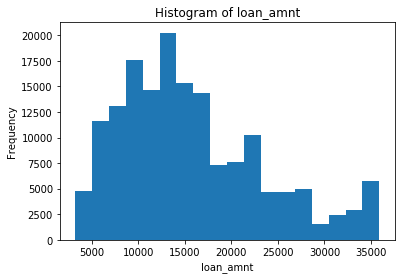

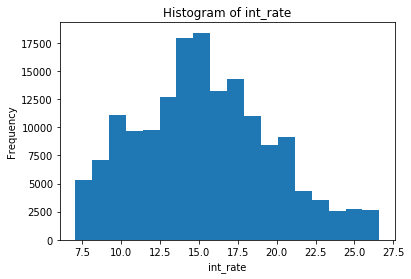

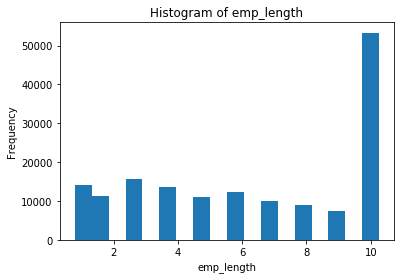

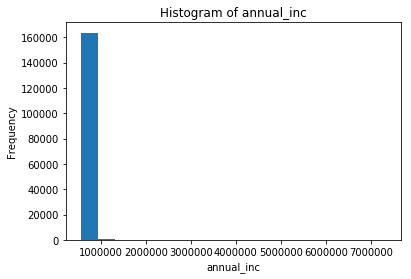

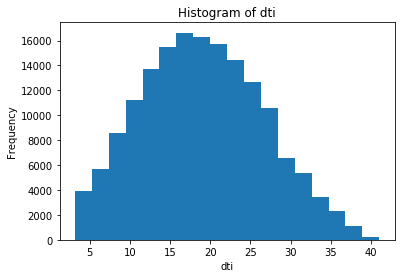

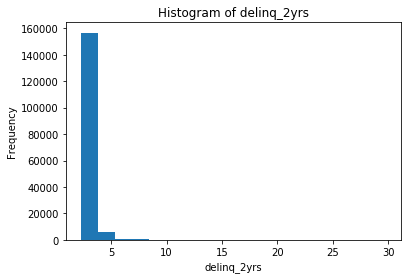

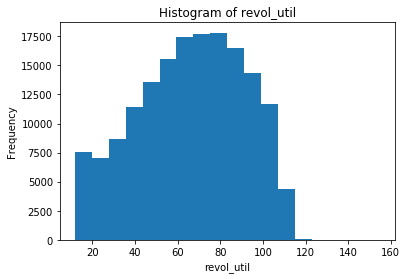

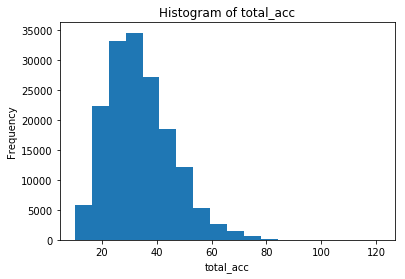

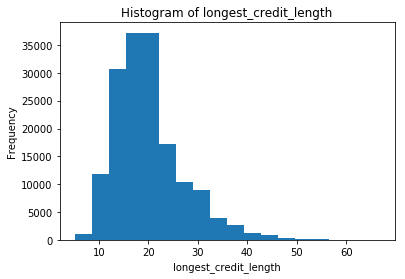

In [17]:
for j in train.columns_by_type("numeric"):
    train[int(j)].hist()
plt.show()

### Feature Engineering in H2O

Since the goal of this analysis is to predict credit card default, we will create a string, `y`, for the response variable, "bad_loan", and a list of column names for the original set of predictors, `x_orig`. The original set of predictors should not include interest rate since they were set based upon a risk assessment that the loan would be bad.

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform three feature engineering tasks:

1. **Separating Typical from Extreme Loan Amount**
1. **Converting Term to a 0/1 Indicator**
1. **Creating Missing Value Indicator for Employment Length**
1. **Combining Categories in Home Ownership**
1. **Separating Typical from Extreme Annual Income**
1. **Creating Target Encoding for Loan Purpose**
1. **Creating Target Encoding for State of Residence**
1. **Separating Typical from Extreme Debt to Income Ratio**
1. **Separating Typical from Extreme Number of Delinquencies in the Past 2 Years**
1. **Separating Typical from Extreme Revolving Credit Line Utilized**
1. **Separating Typical from Extreme Number of Credit Lines**
1. **Separating Typical from Extreme Longest Credit Length**
1. **Converting Income Verification Status to a 0/1 Indicator**

In [18]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

#### Cross Validation and Target Encoding

This analysis will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of the categorical predictors as one hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [19]:
cv_nfolds = 5
cv_seed = 987

In [20]:
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [21]:
train["cv_fold"].table()

cv_fold,Count
0,32818
1,32810
2,33045
3,32570
4,32744


In [22]:
import numpy as np
import pandas as pd

In [23]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [24]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [25]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

#### Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \$5,000 to \$30,000 and is relatively flat below \$5,000 and above \$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
loan\_amnt\_core & = & \max(5000, \min(loan\_amnt, 30000)) \\
loan\_amnt\_diff & = & loan\_amnt - loan\_amnt\_core
\end{eqnarray}

In [26]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [27]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

In [28]:
df = mean_target(train, "loan_amnt_cat")

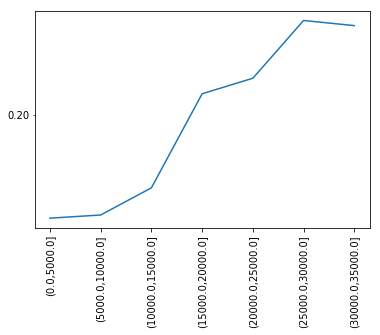

In [29]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])
plt.show()

In [30]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",25785,0.163234
1,"(5000.0,10000.0]",50384,0.164278
2,"(10000.0,15000.0]",35552,0.173436
3,"(15000.0,20000.0]",24659,0.208281
4,"(20000.0,25000.0]",14447,0.214508
5,"(25000.0,30000.0]",6913,0.238825
6,"(30000.0,35000.0]",6247,0.236594


In [31]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

#### Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [32]:
train["term"].table()

term,Count
36 months,129950
60 months,34037


In [33]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

In [34]:
train["term_60months"].table()

term_60months,Count
0,129950
1,34037


#### Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [35]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.68435293299533
maxs,10.0
sigma,3.6106637311002365
zeros,14248
missing,5804
0,10.0
1,0.0
2,10.0


In [36]:
x_trans.append("emp_length_missing")

train["emp_length_missing"] = train["emp_length"] == None

In [37]:
mean_target_encoding(train, "emp_length_missing")

/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.51627
1,0,-1.04832
0,1,-1.5119
1,1,-1.00873
0,2,-1.52094
1,2,-1.03431
0,3,-1.51924
1,3,-1.02358
0,4,-1.50977
1,4,-1.04019


In [38]:
df = mean_target(train, "emp_length")

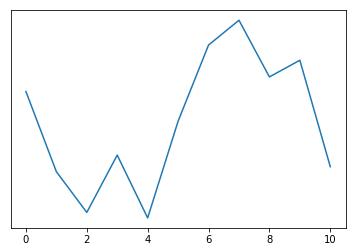

In [39]:
plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])
plt.show()

In [40]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.262922
1,0.0,14248,0.184307
2,1.0,11414,0.177238
3,2.0,15766,0.173728
4,3.0,13611,0.178679
5,4.0,11024,0.173258
6,5.0,12347,0.181664
7,6.0,10000,0.188500
8,7.0,9079,0.190770
9,8.0,7424,0.185614


#### Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [41]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,79714,0.164137
2,NONE,30,0.233333
3,OTHER,156,0.224359
4,OWN,13560,0.188348
5,RENT,70526,0.203273


In [42]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()

In [43]:
train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
ANY,OTHER,1
MORTGAGE,MORTGAGE,79714
NONE,OTHER,30
OTHER,OTHER,156
OWN,OWN,13560
RENT,OTHER,70526


In [44]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,79714,0.164137
1,OTHER,70713,0.203329
2,OWN,13560,0.188348


In [45]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

#### Separating Typical from Extreme Annual Income

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \$10,000 to \$105,000 and is relatively flat above \$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
annual\_inc\_core & = & \max(10000, \min(annual\_inc, 105000)) \\
annual\_inc\_diff & = & annual\_inc - annual\_inc\_core
\end{eqnarray}

In [46]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,1896
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,145000
1,7.14178e+06


In [47]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

In [48]:
df = mean_target(train, "annual_inc_cat")

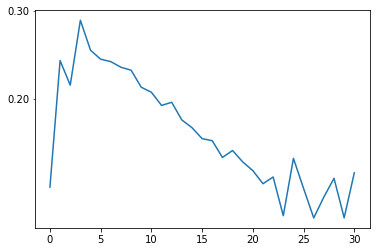

In [49]:
plt.yscale("logit")
plt.plot(df["annual_inc_cat"].index, df["mean_bad_loan"])
plt.show()

In [50]:
df[0:6]

,annual_inc_cat,nrow,mean_bad_loan
0,NaN,0,0.126695
1,"(0.0,5000.0]",25,0.240000
2,"(5000.0,10000.0]",192,0.213542
3,"(10000.0,15000.0]",868,0.288018
4,"(15000.0,20000.0]",1847,0.251760
5,"(20000.0,25000.0]",3975,0.241509


In [51]:
df[20:31]

,annual_inc_cat,nrow,mean_bad_loan
20,"(95000.0,100000.0]",5473,0.138315
21,"(100000.0,105000.0]",2860,0.129021
22,"(105000.0,110000.0]",3275,0.133740
23,"(110000.0,115000.0]",1908,0.108491
24,"(115000.0,120000.0]",3009,0.147557
25,"(120000.0,125000.0]",1741,0.125790
26,"(125000.0,130000.0]",1642,0.107186
27,"(130000.0,135000.0]",974,0.120123
28,"(135000.0,140000.0]",1235,0.132794
29,"(140000.0,145000.0]",746,0.107239


In [52]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

#### Creating Target Encoding for Loan Purpose

Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting of the later group.

In [53]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  93261    56.87
1          credit_card  30792    18.78
2                other  10492     6.40
3     home_improvement   9872     6.02
4       major_purchase   4686     2.86
5       small_business   3841     2.34
6                  car   2842     1.73
7              medical   2029     1.24
8              wedding   1751     1.07
9               moving   1464     0.89
10               house   1245     0.76
11            vacation   1096     0.67
12         educational    418     0.25
13    renewable_energy    198     0.12


In [54]:
mean_target(train, "purpose")

,purpose,nrow,mean_bad_loan
0,car,2842,0.125968
1,credit_card,30792,0.157281
2,debt_consolidation,93261,0.189479
3,educational,418,0.210526
4,home_improvement,9872,0.155895
5,house,1245,0.182329
6,major_purchase,4686,0.137217
7,medical,2029,0.203056
8,moving,1464,0.207650
9,other,10492,0.214354


In [55]:
te_purpose = mean_target_encoding(train, "purpose")

/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [56]:
train = train.merge(te_purpose, all_x = True)

In [57]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

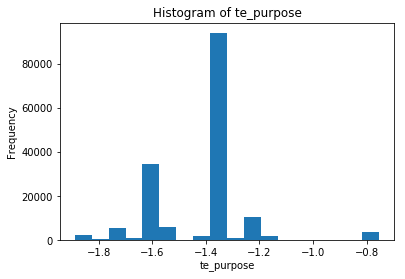

In [58]:
train["te_purpose"].hist()

#### Creating Target Encoding for State of Residence

We will also use a mean target encoding for state of residence for a reason similar to that for purpose.

In [59]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:5])

  addr_state  Count  Percent
0         CA  28702    17.50
1         NY  14285     8.71
2         TX  12128     7.40
3         FL  11396     6.95
4         NJ   6457     3.94


In [60]:
df = mean_target(train, "addr_state")

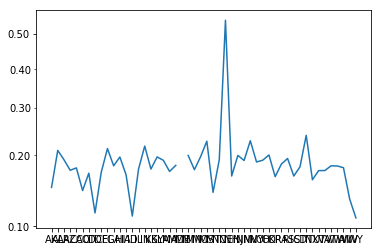

In [61]:
plt.yscale("logit")
plt.plot(df["addr_state"], df["mean_bad_loan"])
plt.show()

In [62]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [63]:
train = train.merge(te_addr_state, all_x = True)

In [64]:
x_trans.remove("addr_state")
x_trans.append("te_addr_state")

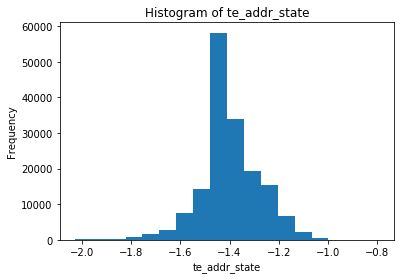

In [65]:
train["te_addr_state"].hist()

#### Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
dti\_core & = & \max(5, \min(dti, 30)) \\
dti\_diff & = & dti - dti\_core
\end{eqnarray}

In [66]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.79
0.25,10.23
0.5,15.62
0.75,21.26
0.95,29.02
1,39.99


In [67]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

In [68]:
df = mean_target(train, "dti_cat")

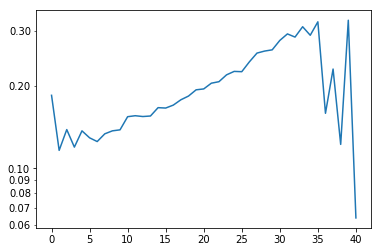

In [69]:
plt.yscale("logit")
plt.plot(df["dti_cat"].index, df["mean_bad_loan"])
plt.show()

In [70]:
df[30:41]

,dti_cat,nrow,mean_bad_loan
30,"(29.0,30.0]",2329,0.280378
31,"(30.0,31.0]",1496,0.293449
32,"(31.0,32.0]",1282,0.287051
33,"(32.0,33.0]",1051,0.308278
34,"(33.0,34.0]",1025,0.290732
35,"(34.0,35.0]",750,0.318667
36,"(35.0,36.0]",75,0.160000
37,"(36.0,37.0]",66,0.227273
38,"(37.0,38.0]",65,0.123077
39,"(38.0,39.0]",59,0.322034


In [71]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

#### Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
delinq\_2yrs\_core & = & \min(delinq\_2yrs, 3) \\
delinq\_2yrs\_diff & = & delinq\_2yrs - delinq\_2yrs\_core
\end{eqnarray}

In [72]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,29


In [73]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

In [74]:
mean_target(train, "delinq_2yrs_cat")

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.181037
1,"(0.0,1.0]",17158,0.189299
2,"(1.0,2.0]",4635,0.201510
3,"(2.0,3.0]",1488,0.221774
4,"(3.0,4.0]",579,0.215889
5,"(4.0,5.0]",310,0.216129


In [75]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)

train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

#### Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
revol\_util\_0 & = & I(revol\_util == 0) \\
revol\_util\_core & = & \max(5, \min(revol\_util, 30)) \\
revol\_util\_diff & = & revol\_util - revol\_util\_core
\end{eqnarray}

In [76]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.2
0.95,92.5
1,150.7


In [77]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

In [78]:
df = mean_target(train, "revol_util_cat")

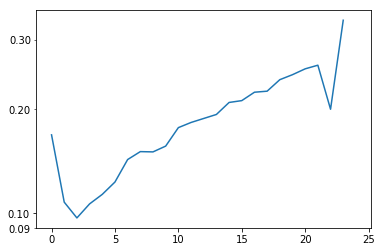

In [79]:
plt.yscale("logit")
plt.plot(df["revol_util_cat"].index, df["mean_bad_loan"])
plt.show()

In [80]:
df[20:25]

,revol_util_cat,nrow,mean_bad_loan
20,"(95.0,100.0]",4316,0.255097
21,"(100.0,105.0]",238,0.260504
22,"(105.0,110.0]",35,0.200000
23,"(110.0,115.0]",9,0.333333
24,"(115.0,120.0]",3,0.000000


In [81]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0

train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)

train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

#### Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
total\_acc\_core & = & \min(total\_acc, 50) \\
total\_acc\_diff & = & total\_acc - total\_acc\_core
\end{eqnarray}

In [82]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,118


In [83]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

In [84]:
df = mean_target(train, "total_acc_cat")

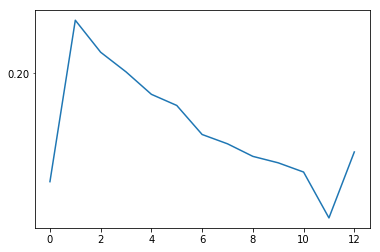

In [85]:
plt.yscale("logit")
plt.plot(df["total_acc_cat"].index, df["mean_bad_loan"])
plt.show()

In [86]:
(train["total_acc"] == None).table()

C1,Count
0,163958
1,29


In [87]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.153788
1,"(0.0,5.0]",2309,0.226072
2,"(5.0,10.0]",12717,0.210034


In [88]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",11251,0.163719
9,"(40.0,45.0]",7174,0.161137
10,"(45.0,50.0]",4203,0.157507
11,"(50.0,55.0]",2350,0.140426
12,"(55.0,60.0]",1287,0.165501


In [89]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)

train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

#### Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
longest\_credit\_length\_core & = & \max(3, \min(longest\_credit\_length, 20)) \\
longest\_credit\_length\_diff & = & longest\_credit\_length - longest\_credit\_length\_core
\end{eqnarray}

In [90]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [91]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

In [92]:
df = mean_target(train, "longest_credit_length_cat")

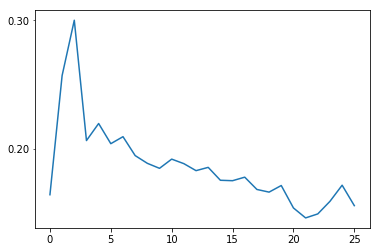

In [93]:
plt.yscale("logit")
plt.plot(df["longest_credit_length_cat"].index, df["mean_bad_loan"])
plt.show()

In [94]:
df[0:4]

,longest_credit_length_cat,nrow,mean_bad_loan
0,NaN,0,0.171094
1,"(0.0,1.0]",67,0.253731
2,"(1.0,2.0]",100,0.300000
3,"(2.0,3.0]",914,0.205689


In [95]:
df[20:26]

,longest_credit_length_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",4682,0.163392
21,"(20.0,21.0]",3892,0.157760
22,"(21.0,22.0]",3350,0.160000
23,"(22.0,23.0]",3092,0.167206
24,"(23.0,24.0]",2856,0.176821
25,"(24.0,25.0]",2471,0.164711


In [96]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)

train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

#### Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [97]:
train["verification_status"].table()

verification_status,Count
not verified,59155
verified,104832


In [98]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"

In [99]:
train["verified"].table()

verified,Count
0,59155
1,104832


#### Saving the Transformed Data to a Known Key

To make it easier to find the data in the cluster, we will [`assign`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=assign#h2o.assign) the transformed data set to a known key and then retrieving that frame using the [`get_frame`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/h2o.html?highlight=get_frame#h2o.get_frame) function.

In [100]:
print(train.frame_id)

py_204_sid_b77f


In [101]:
h2o.assign(train, "loan_transformed")
train = h2o.get_frame("loan_transformed")
print(train.frame_id)

loan_transformed


## Supervised Learning in H2O

This exploration will employ six different supervised learning techniques:

1. [Generalized Linear Model](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogeneralizedlinearestimator)
1. [Random Forest](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2orandomforestestimator)
1. [Gradient Boosting Machine](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogradientboostingestimator)
1. [Multilayer Perceptron (Deep Learning)](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
1. [Stacked Ensembles](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ostackedensembleestimator)
1. [Automatic Machine Learning (AutoML)](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oautoml)

H2O has two other superviesed learning techiques, [Naive Bayes Classifier](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2onaivebayesestimator) and [eXtreme Gradient Boosting (XGBoost)](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator), that are left for the reader to explore outside of this script.

Given we only have 163987 rows of data, we will use cross-validation to detect overfitting rather than creating a separate validation split.

In [102]:
print("Response = " + y)
print("Predictors (Orig) = " + str(x_orig))
print("Predictors (Trans) = " + str(x_trans))

Response = bad_loan
Predictors (Orig) = ['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']
Predictors (Trans) = ['emp_length', 'loan_amnt_core', 'loan_amnt_delta', 'term_60months', 'emp_length_missing', 'home_ownership_3cat', 'annual_inc_core', 'annual_inc_delta', 'te_purpose', 'te_addr_state', 'dti_core', 'dti_delta', 'delinq_2yrs_core', 'delinq_2yrs_delta', 'revol_util_0', 'revol_util_core', 'revol_util_delta', 'total_acc_core', 'total_acc_delta', 'longest_credit_length_core', 'longest_credit_length_delta', 'verified']


### Generalized Linear Model : Logistic Regression

#### Initial Models

Following standard convention for binary classification exercises, we will start with logistic regression. From Python, H2O uses a scikit-learn like [`H2OGeneralizedLinearEstimator`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html?highlight=h2ogeneralizedlinearestimator#h2o.estimators.glm.H2OGeneralizedLinearEstimator) to fit a couple of models. The first model we will fit uses the original set of predictors and the second model uses the engineered features. As is expected, the logistic regression model containing the engineered features have a lower cross-validated logloss and a higher cross-validated AUC than the model with the original features.

In [103]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [104]:
help(H2OGeneralizedLinearEstimator)

Help on class H2OGeneralizedLinearEstimator in module h2o.estimators.glm:

class H2OGeneralizedLinearEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Generalized Linear Modeling
 |  
 |  Fits a generalized linear model, specified by a response variable, a set of predictors, and a
 |  description of the error distribution.
 |  
 |  A subclass of :class:`ModelBase` is returned. The specific subclass depends on the machine learning task
 |  at hand (if it's binomial classification, then an H2OBinomialModel is returned, if it's regression then a
 |  H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific
 |  information can be queried out of the object. Upon completion of the GLM, the resulting object has
 |  coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including
 |  MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.
 |  
 |  Method resolution order:
 |  

In [105]:
glm_orig_0 = H2OGeneralizedLinearEstimator(family = "binomial", lambda_search = True,
                                           nfolds = cv_nfolds, fold_column = "cv_fold")
glm_trans_0 = H2OGeneralizedLinearEstimator(family = "binomial", lambda_search = True,
                                            nfolds = cv_nfolds, fold_column = "cv_fold")

In [106]:
glm_orig_0.train(x = x_orig, y = y, training_frame = train, model_id = "bad_loan_glm_orig_0")
glm_trans_0.train(x = x_trans, y = y, training_frame = train, model_id = "bad_loan_glm_trans_0")

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [107]:
print("Log Loss_GLM(orig)  = {:0.4f}".format(glm_orig_0.logloss(xval = True)))
print("Log Loss_GLM(trans) = {:0.4f}".format(glm_trans_0.logloss(xval = True)))

Log Loss_GLM(orig)  = 0.4477
Log Loss_GLM(trans) = 0.4457


In [108]:
print("AUC_GLM(orig)  = {:0.4f}".format(glm_orig_0.auc(xval = True)))
print("AUC_GLM(trans) = {:0.4f}".format(glm_trans_0.auc(xval = True)))

AUC_GLM(orig)  = 0.6738
AUC_GLM(trans) = 0.6772


#### Regularization Path

The [`H2OGeneralizedLinearEstimator.getGLMRegularizationPath`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html?highlight=getglmregularizationpath#h2o.estimators.glm.H2OGeneralizedLinearEstimator.getGLMRegularizationPath) method extracts the regularization path from the lambda search.

In [109]:
reg_path = H2OGeneralizedLinearEstimator.getGLMRegularizationPath(glm_trans_0)

In [110]:
print(reg_path.keys())

dict_keys(['lambdas', 'explained_deviance_train', 'explained_deviance_valid', 'coefficients', 'coefficients_std'])


In [111]:
reg_path_df = \
    pd.concat([pd.DataFrame({'lambdas': reg_path['lambdas'],
                             'explained_deviance_train': reg_path['explained_deviance_train']}),
               pd.DataFrame(reg_path['coefficients_std'])], axis = 1)
reg_path_df

,lambdas,explained_deviance_train,Intercept,annual_inc_core,annual_inc_delta,delinq_2yrs_core,delinq_2yrs_delta,dti_core,dti_delta,emp_length,...,longest_credit_length_delta,revol_util_0,revol_util_core,revol_util_delta,te_addr_state,te_purpose,term_60months,total_acc_core,total_acc_delta,verified
0,0.114482,-1.554312e-13,-1.495893,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.104312,2.907636e-03,-1.496091,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000
2,0.095045,5.458983e-03,-1.496641,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.048511,0.000000,0.000000,0.000000
3,0.086601,7.687483e-03,-1.497478,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.070564,0.000000,0.000000,0.000000
4,0.078908,9.966709e-03,-1.498416,0.000000,0.0,0.000000,0.0,0.002666,0.000000,0.000000,...,0.000000,0.000000,0.001528,0.0,0.000000,0.000000,0.091097,0.000000,0.000000,0.000000
5,0.071898,1.527707e-02,-1.500107,-0.016700,0.0,0.000000,0.0,0.015053,0.000000,0.000000,...,0.000000,0.000000,0.017942,0.0,0.000000,0.000000,0.110452,0.000000,0.000000,0.000000
6,0.065511,2.018967e-02,-1.502328,-0.036021,0.0,0.000000,0.0,0.026017,0.000000,0.000000,...,0.000000,0.000000,0.033752,0.0,0.000000,0.000000,0.129076,0.000000,0.000000,0.000000
7,0.059691,2.447512e-02,-1.505095,-0.054450,0.0,0.000000,0.0,0.036161,0.000000,0.000000,...,0.000000,0.000000,0.048754,0.0,0.000000,0.000000,0.146518,0.000000,0.000000,0.000000
8,0.054388,2.820458e-02,-1.508291,-0.071992,0.0,0.000000,0.0,0.045541,0.000000,0.000000,...,0.000000,0.000000,0.062966,0.0,0.000000,0.000000,0.162835,0.000000,0.000000,0.000000
9,0.049556,3.179152e-02,-1.511836,-0.088584,0.0,0.000000,0.0,0.054138,0.000000,0.000000,...,0.000000,0.000000,0.076372,0.0,0.000000,0.006896,0.177920,0.000000,0.000000,0.000000


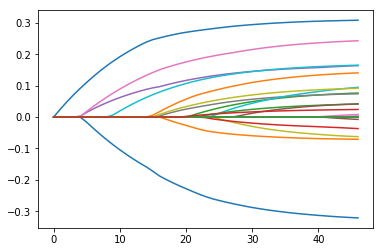

In [112]:
plt.plot(reg_path_df.iloc[:, 3:27])
plt.show()

#### Grid Search Over Hyper-Parameters

In general, machine learning models require hyper-parameter tuning to capture the signal in the data without overfitting the noise. To aid in this effort, H2O provides and [`H2OGridSearch`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html?highlight=h2ogridsearch#h2o.grid.grid_search.H2OGridSearch) framework to automate hyper-parameter exploration.

In the context of logistic regression, the most important hyper-parameter is `alpha`, which balances the importance given to L1 and L2 regularization on the coefficient estimates. When `alpha = 0` only L2 regularization is used (ridge regression), when `alpha = 1` only L1 regularization is used (Least Absolute Shrinkage and Selection Operator (LASSO)), and when `alpha` is somewhere in-between a combination of the two are used (elastic-net).

In [113]:
from h2o.grid.grid_search import H2OGridSearch

In [114]:
help(H2OGridSearch)

Help on class H2OGridSearch in module h2o.grid.grid_search:

class H2OGridSearch(h2o.utils.backward_compatibility.BackwardsCompatibleBase)
 |  Grid Search of a Hyper-Parameter Space for a Model
 |  
 |  :param model: The type of model to be explored initialized with optional parameters that will be
 |      unchanged across explored models.
 |  :param hyper_params: A dictionary of string parameters (keys) and a list of values to be explored by grid
 |      search (values).
 |  :param str grid_id: The unique id assigned to the resulting grid object. If none is given, an id will
 |      automatically be generated.
 |  :param search_criteria:  A dictionary of directives which control the search of the hyperparameter space.
 |      The default strategy "Cartesian" covers the entire space of hyperparameter combinations. Specify the
 |      "RandomDiscrete" strategy to get random search of all the combinations of your hyperparameters.
 |      RandomDiscrete should usually be combined with at 

In [115]:
glm_hyper_parameters = {"alpha": [0.05, 0.5, 0.95]}

j = 0
while j < len(x_trans):
    j = j + 1
    glm_grid = H2OGridSearch(H2OGeneralizedLinearEstimator(family = "binomial", lambda_search = True,
                                                           fold_column = "cv_fold",
                                                           keep_cross_validation_predictions = True,
                                                           max_active_predictors = j),
                             glm_hyper_parameters)
    glm_grid.train(x = x_trans, y = y, training_frame = train, grid_id = "bad_loan_glm_grid")

glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Grid Build progress: |██

In [116]:
glm_grid.show()

        alpha                   model_ids              logloss
0      [0.05]  bad_loan_glm_grid_model_60  0.44575379665894127
1      [0.05]  bad_loan_glm_grid_model_63   0.4457543478932118
2      [0.05]  bad_loan_glm_grid_model_57   0.4457581913003404
3      [0.95]  bad_loan_glm_grid_model_53  0.44577010351867563
4      [0.95]  bad_loan_glm_grid_model_56   0.4457705343610416
5      [0.95]  bad_loan_glm_grid_model_62   0.4457705343610416
6      [0.95]  bad_loan_glm_grid_model_59   0.4457705343610416
7      [0.95]  bad_loan_glm_grid_model_65   0.4457705343610416
8       [0.5]  bad_loan_glm_grid_model_61  0.44577054890084056
9       [0.5]  bad_loan_glm_grid_model_55  0.44577054890084056
10      [0.5]  bad_loan_glm_grid_model_58  0.44577054890084056
11      [0.5]  bad_loan_glm_grid_model_64  0.44577054890084056
12     [0.95]  bad_loan_glm_grid_model_47   0.4457708230897978
13      [0.5]  bad_loan_glm_grid_model_46   0.4457713492545339
14     [0.95]  bad_loan_glm_grid_model_50   0.445771429

In [117]:
sorted((v, k) for (k,v) in glm_grid.aic(xval = True).items())

[(146235.23993205334, 'bad_loan_glm_grid_model_47'),
 (146235.4125004065, 'bad_loan_glm_grid_model_46'),
 (146237.43881260048, 'bad_loan_glm_grid_model_50'),
 (146237.67147915644, 'bad_loan_glm_grid_model_49'),
 (146239.00393143413, 'bad_loan_glm_grid_model_53'),
 (146239.09703353784, 'bad_loan_glm_grid_model_57'),
 (146239.65570541957, 'bad_loan_glm_grid_model_60'),
 (146239.83649592823, 'bad_loan_glm_grid_model_63'),
 (146239.87749800668, 'bad_loan_glm_grid_model_52'),
 (146241.14523652825, 'bad_loan_glm_grid_model_56'),
 (146241.14523652825, 'bad_loan_glm_grid_model_59'),
 (146241.14523652825, 'bad_loan_glm_grid_model_62'),
 (146241.14523652825, 'bad_loan_glm_grid_model_65'),
 (146241.15000520425, 'bad_loan_glm_grid_model_55'),
 (146243.15000520425, 'bad_loan_glm_grid_model_58'),
 (146243.15000520425, 'bad_loan_glm_grid_model_61'),
 (146243.15000520425, 'bad_loan_glm_grid_model_64'),
 (146244.23290274042, 'bad_loan_glm_grid_model_51'),
 (146246.5621521726, 'bad_loan_glm_grid_model_5

In [118]:
glm_best = glm_grid.models[0]
"Number of non-zero coefs = {}".format(sum(x != 0 for x in glm_best.coef().values()))

'Number of non-zero coefs = 22'

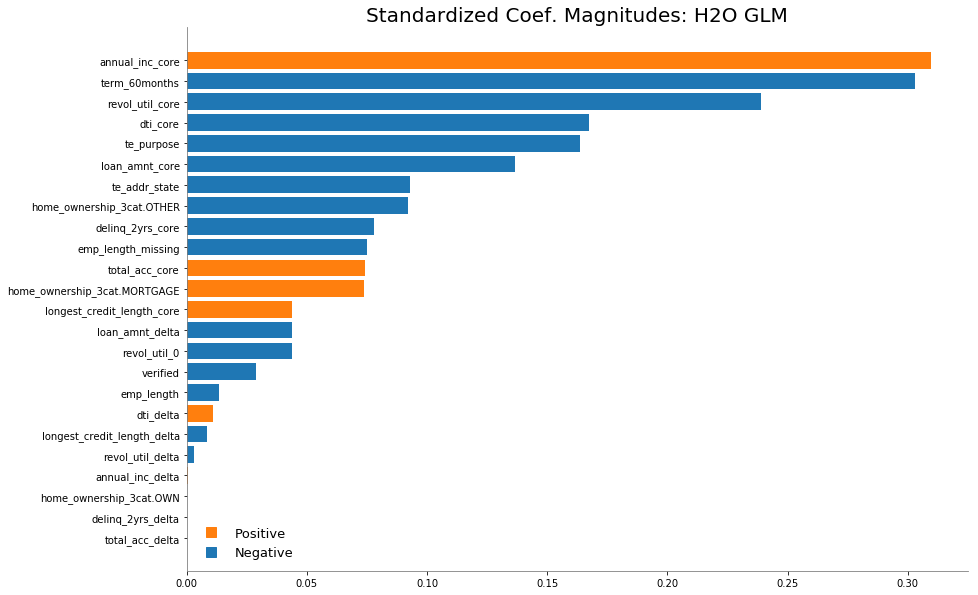

In [119]:
glm_best.std_coef_plot()

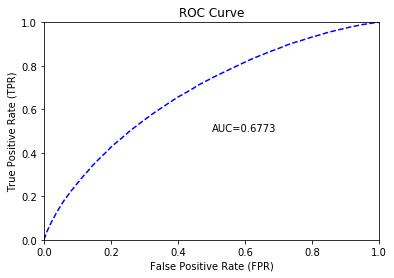

In [120]:
glm_best.model_performance(xval = True).plot()

In [121]:
glm_best.predict(train)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.96999,0.03001
0,0.807572,0.192428
0,0.866912,0.133088
0,0.952953,0.0470467
0,0.901452,0.0985483
1,0.787788,0.212212
1,0.650202,0.349798
1,0.685619,0.314381
1,0.768092,0.231908
0,0.828937,0.171063
